# Quantum Circuits Dataset Sanity and Entropy Analysis
This notebook checks the integrity and basic statistics of all quantum circuit graph datasets (all qubit sizes, both circuit classes, noisy/noiseless).
For each dataset:

- It verifies feature/target shapes and detects NaN values.
- It prints summary statistics for node, edge, global, and target arrays.
- It visualizes output entropy distributions to assess data diversity.

These checks support reliable model training and ensure correct handling of input/output dimensions, and are also important for identifying unexpected data issues.

At the end, a hardware noise calibration snapshot is loaded to show its structure.

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import entropy as shannon_entropy
import json

## Sanity Check

In [3]:
#path
base = "../datasets"

# get datasets, traversing directory structure
datasets = {}
for nq in os.listdir(base):
    nq_path = os.path.join(base, nq)
    if not os.path.isdir(nq_path): continue
    n_qubits = int(nq.split('-')[0])
    datasets[n_qubits] = {}
    for noise in os.listdir(nq_path):
        noise_path = os.path.join(nq_path, noise)
        if not os.path.isdir(noise_path): continue
        datasets[n_qubits][noise] = {}
        for cls in os.listdir(noise_path):
            cls_path = os.path.join(noise_path, cls)
            if not os.path.isdir(cls_path): continue
            ptfiles = [f for f in os.listdir(cls_path) if f.endswith('.pt')]
            for fname in ptfiles:
                data = torch.load(os.path.join(cls_path, fname))
                datasets[n_qubits][noise][cls] = data
                print(f"Loaded {len(data)} samples: {n_qubits} qubits | {noise} | {cls}")

Loaded 2400 samples: 2 qubits | noiseless | classA
Loaded 2400 samples: 2 qubits | noiseless | classB
Loaded 2400 samples: 2 qubits | noisy | classA
Loaded 2400 samples: 2 qubits | noisy | classB
Loaded 4800 samples: 3 qubits | noiseless | classA
Loaded 4800 samples: 3 qubits | noiseless | classB
Loaded 4800 samples: 3 qubits | noisy | classA
Loaded 4800 samples: 3 qubits | noisy | classB
Loaded 9600 samples: 4 qubits | noiseless | classA
Loaded 9600 samples: 4 qubits | noiseless | classB
Loaded 9600 samples: 4 qubits | noisy | classA
Loaded 9600 samples: 4 qubits | noisy | classB
Loaded 19200 samples: 5 qubits | noiseless | classA
Loaded 19200 samples: 5 qubits | noiseless | classB
Loaded 19200 samples: 5 qubits | noisy | classA
Loaded 19200 samples: 5 qubits | noisy | classB


In [4]:
# Iterate over all datasets by qubit count, noise type, and circuit class to inspect sample shapes and NaN presence
for n_qubits in sorted(datasets.keys()):
    for noise in datasets[n_qubits]:
        for class_name in datasets[n_qubits][noise]:
            data = datasets[n_qubits][noise][class_name]
            node_shapes = [d.x.shape for d in data[:3]]
            edge_shapes = [d.edge_index.shape for d in data[:3]]
            u_shapes = [d.u.shape for d in data[:3]]
            y_shapes = [d.y.shape for d in data[:3]]
            nan_count = sum(torch.isnan(d.x).any() or torch.isnan(d.u).any() or torch.isnan(d.y).any() for d in data)
            print(f"\nDataset: {n_qubits}q | {noise} | {class_name}")
            print(f"First 3 node feature shapes: {node_shapes}")
            print(f"First 3 edge_index shapes: {edge_shapes}")
            print(f"First 3 global feature (u) shapes: {u_shapes}")
            print(f"First 3 target (y) shapes: {y_shapes}")
            print(f"Samples with NaNs: {nan_count}")

            if len(data) > 0:
                ex = data[0]
                print("  Example sample [0]:")
                print("    Node features (x) shape:", ex.x.shape)
                print("    Edge_index shape:", ex.edge_index.shape)
                print("    Edge_attr shape:", ex.edge_attr.shape)
                print("    Global features (u) shape:", ex.u.shape)
                print("    Target (y) shape:", ex.y.shape)
                print("    Graph num nodes:", ex.num_nodes)
                print("    Graph num edges:", ex.num_edges)
            else:
                print("  Dataset is empty.")


Dataset: 2q | noiseless | classA
First 3 node feature shapes: [torch.Size([3, 27]), torch.Size([3, 27]), torch.Size([3, 27])]
First 3 edge_index shapes: [torch.Size([2, 2]), torch.Size([2, 2]), torch.Size([2, 2])]
First 3 global feature (u) shapes: [torch.Size([9]), torch.Size([9]), torch.Size([9])]
First 3 target (y) shapes: [torch.Size([4]), torch.Size([4]), torch.Size([4])]
Samples with NaNs: 0
  Example sample [0]:
    Node features (x) shape: torch.Size([3, 27])
    Edge_index shape: torch.Size([2, 2])
    Edge_attr shape: torch.Size([2, 3])
    Global features (u) shape: torch.Size([9])
    Target (y) shape: torch.Size([4])
    Graph num nodes: 3
    Graph num edges: 2

Dataset: 2q | noiseless | classB
First 3 node feature shapes: [torch.Size([7, 27]), torch.Size([7, 27]), torch.Size([7, 27])]
First 3 edge_index shapes: [torch.Size([2, 7]), torch.Size([2, 7]), torch.Size([2, 7])]
First 3 global feature (u) shapes: [torch.Size([9]), torch.Size([9]), torch.Size([9])]
First 3 targe

## Entropy

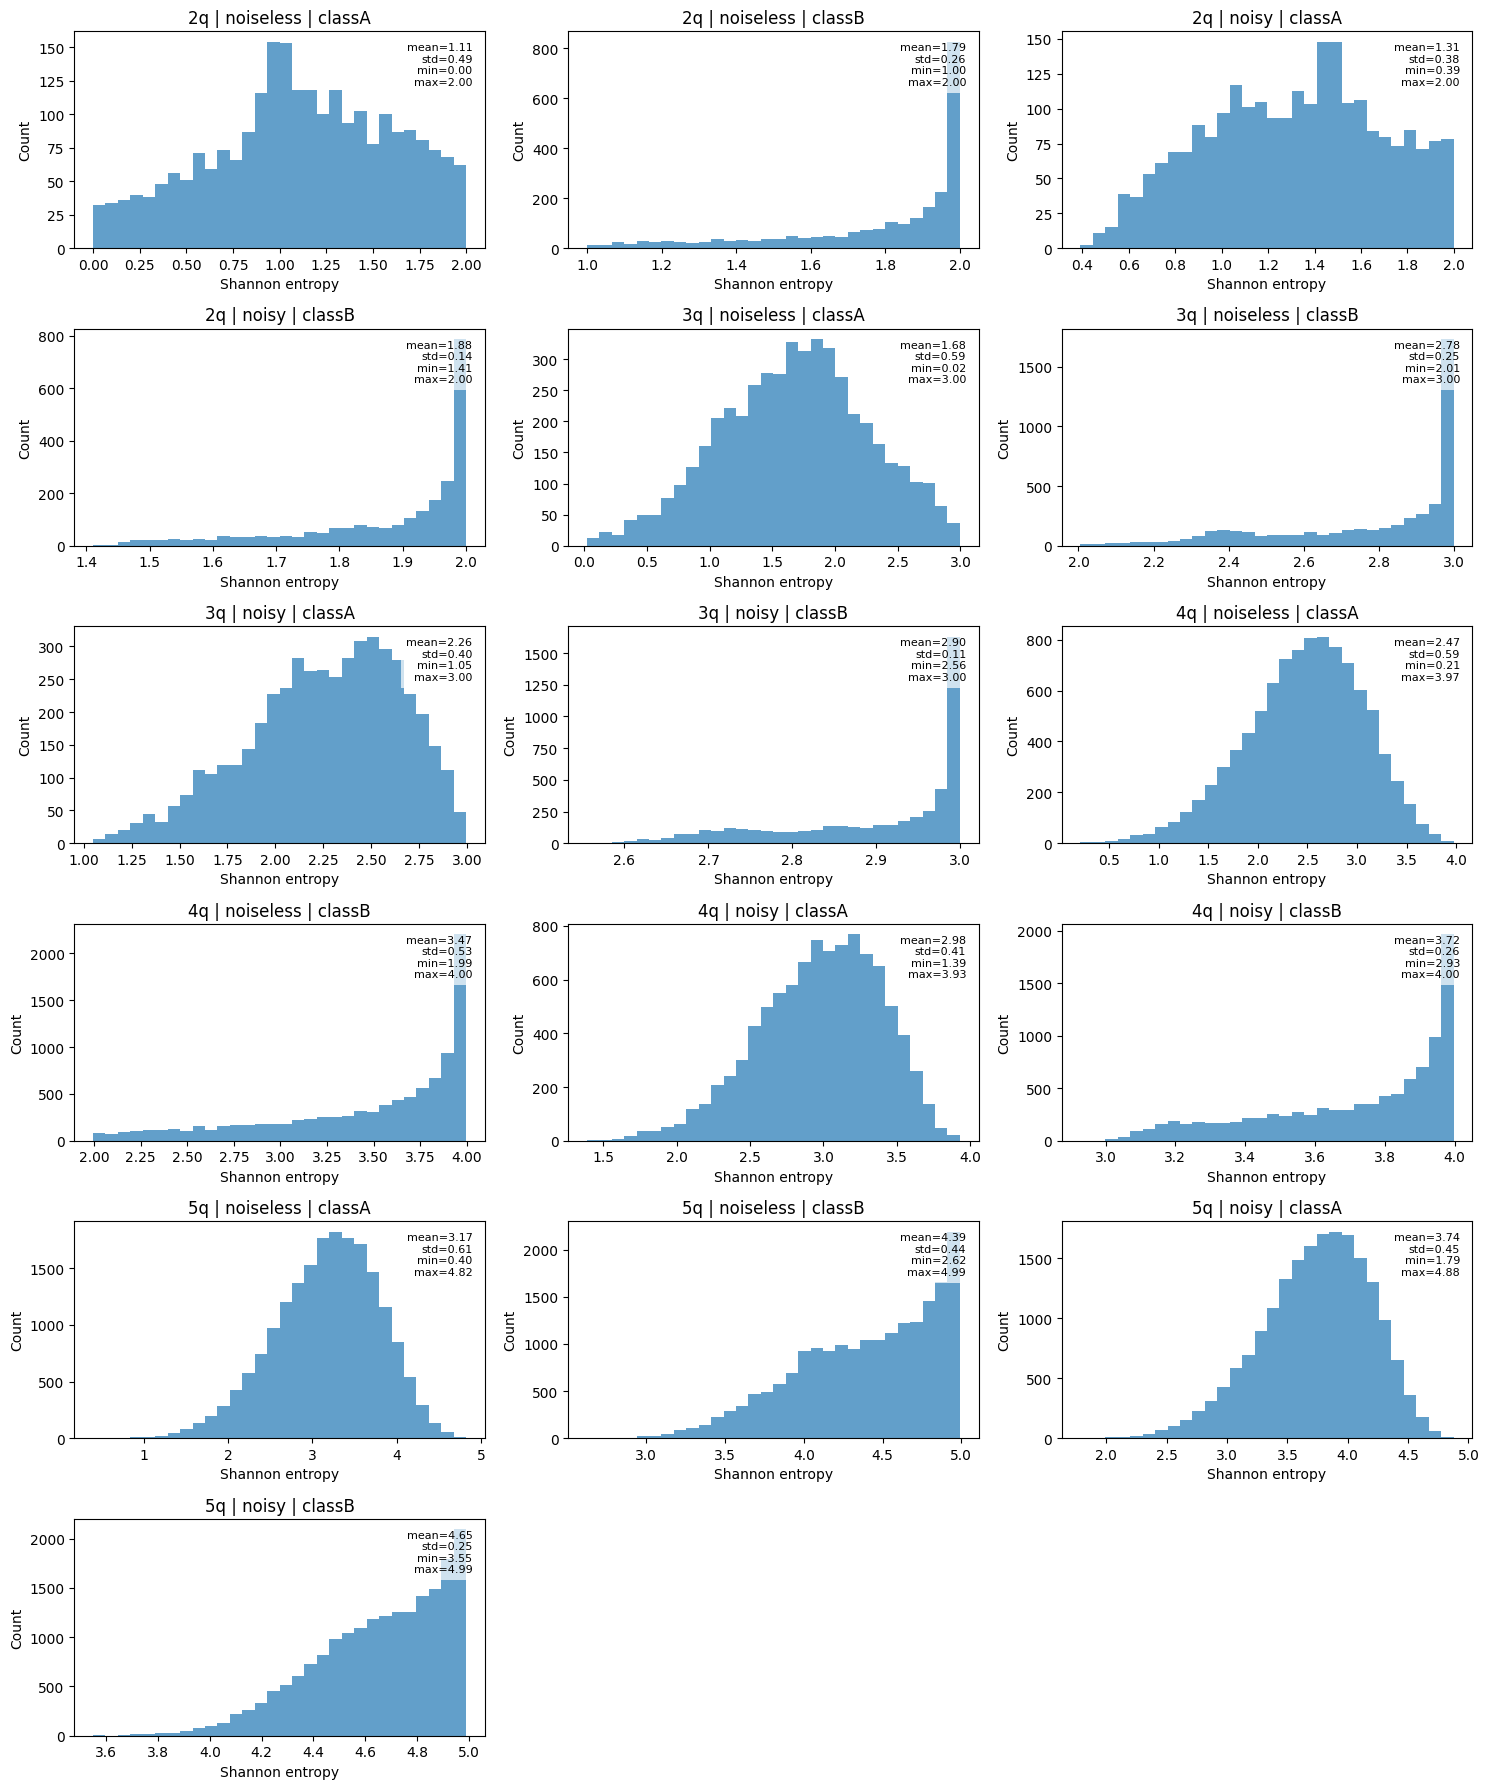

In [5]:
#Func to compute shannon entropy
def shannon_entropy(y):
    y = np.asarray(y)
    y = y / (y.sum() + 1e-8)
    y = np.clip(y, 1e-10, 1)
    return -np.sum(y * np.log2(y))

# Collect all datasets for plotting
all_entries = []
all_labels = []
all_stats = []

for n_qubits in sorted(datasets.keys()):
    for noise in datasets[n_qubits]:
        for c in datasets[n_qubits][noise]:
            label = f"{n_qubits}q | {noise} | {c}"
            dat = datasets[n_qubits][noise][c]
            Y = torch.stack([d.y for d in dat]).cpu().numpy()
            entropies = np.array([shannon_entropy(y) for y in Y])
            all_entries.append(entropies)
            all_labels.append(label)
            all_stats.append((entropies.mean(), entropies.std(), entropies.min(), entropies.max()))

# Calculate grid size
N = len(all_entries)
cols = 3
rows = int(np.ceil(N / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 3), squeeze=False)

for i, (entropies, label, stats) in enumerate(zip(all_entries, all_labels, all_stats)):
    r, c = divmod(i, cols)
    ax = axes[r][c]
    ax.hist(entropies, bins=30, alpha=0.7)
    ax.set_title(label)
    ax.set_xlabel("Shannon entropy")
    ax.set_ylabel("Count")
    m, s, mn, mx = stats
    ax.text(0.97, 0.95, f"mean={m:.2f}\nstd={s:.2f}\nmin={mn:.2f}\nmax={mx:.2f}", 
            ha='right', va='top', transform=ax.transAxes, fontsize=8, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

#Hide empty subplots
for j in range(N, rows * cols):
    r, c = divmod(j, cols)
    axes[r][c].axis('off')

plt.tight_layout()
plt.show()

## Sample noise calibration snapshot (5-qubit)

In [6]:
# Path to the JSON file
json_path = "../datasets/5-qubit/noisy/calibration_5q_noisy_ibm_sherbrooke_20250715_124747.json"

# Open and load the JSON data
with open(json_path, "r") as f:
    data = json.load(f)

print(data)

{'backend': 'ibm_sherbrooke', 'timestamp': '20250715_124747', 'n_qubits': 5, 'per_qubit_calib': [[3.959535208747541e-09, 2.7618016393220246e-09, 0.0087890625], [2.8238956270036084e-09, 2.5953755149049224e-09, 0.091064453125], [2.380256222438853e-09, 2.6873831537795893e-09, 0.13525390625], [2.973787804680459e-09, 2.5091904757217224e-09, 0.027587890625], [2.5762186318102437e-09, 4.293997058636737e-09, 0.02392578125]], 'per_gate_errors': {'rx_0': 0.0, 'rx_1': 0.0, 'rx_2': 0.0, 'rx_3': 0.0, 'rx_4': 0.0, 'ry_0': 0.0, 'ry_1': 0.0, 'ry_2': 0.0, 'ry_3': 0.0, 'ry_4': 0.0, 'rz_0': 0, 'rz_1': 0, 'rz_2': 0, 'rz_3': 0, 'rz_4': 0, 'h_0': 0.0, 'h_1': 0.0, 'h_2': 0.0, 'h_3': 0.0, 'h_4': 0.0, 'x_0': 9.987401982054362e-05, 'x_1': 0.0002700665491396226, 'x_2': 0.00016095605266436833, 'x_3': 0.00019522501442008816, 'x_4': 0.00020361230940330776, 'y_0': 0.0, 'y_1': 0.0, 'y_2': 0.0, 'y_3': 0.0, 'y_4': 0.0, 'z_0': 0.0, 'z_1': 0.0, 'z_2': 0.0, 'z_3': 0.0, 'z_4': 0.0, 'cx_0_1': 0.0, 'cx_0_2': 0.0, 'cx_0_3': 0.